In [1]:
## Importing Required Libraries

# Libraries for data manipulation
import pandas as pd
import numpy as np

# Libraries for data visualization
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px

# Pre-Processing
from sklearn.model_selection import train_test_split # train-test-split
from sklearn.impute import SimpleImputer, KNNImputer # detect & handle NaNs
from sklearn.preprocessing import OrdinalEncoder, LabelEncoder, OneHotEncoder # Ordinal Encoding, Nominal Encoding
from category_encoders import BinaryEncoder # Nominal Encoding 
from imblearn.under_sampling import RandomUnderSampler # undersampling
from imblearn.over_sampling import RandomOverSampler, SMOTE # oversampling
from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler # Scaling
# Modeling
## 1) Pipeline
from sklearn.pipeline import Pipeline, make_pipeline # to make pipeline
from sklearn.compose import ColumnTransformer, make_column_transformer, make_column_selector # apply pipeline to each column

## 2) Regression Models
from sklearn.linear_model import LinearRegression # if data is small and small_no_features
from sklearn.linear_model import SGDRegressor # if data is large: (can have penalty=constrains)
from sklearn.preprocessing import PolynomialFeatures # for polynomial regresion (then apply scaling after it)
from sklearn.linear_model import Lasso, LassoCV, Ridge, RidgeCV, ElasticNet, ElasticNetCV # Regularization 

## 3) Model Selection (Underfitting vs Overfitting) [bias variance tradeoff => perfect model complexity]
from sklearn.model_selection import cross_val_score, GridSearchCV, RandomizedSearchCV # (Train - Valid - Test) + hyperparameters tunning 
from sklearn.experimental import enable_halving_search_cv
from sklearn.model_selection import HalvingGridSearchCV, HalvingRandomSearchCV # if data / features is large
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error # Evaluate Model: r2=> accuracy, L2-norm: if no outliers, L1-norm: if outliers
from scipy import stats # Confidence Interval of Accuracy / Loss / Utility
import joblib # save model

In [2]:
# dataset link:
# https://www.kaggle.com/datasets/howisusmanali/house-prices-2023-dataset/data

# Understand data

In [3]:
# Read Data
df = pd.read_csv("/kaggle/input/house-price-dataset-csv/House_Price_dataset.csv")
df.head()


,property_type,price,location,city,province_name,latitude,longitude,baths,purpose,bedrooms,date_added,agency,agent,Area Type,Area Size
0,Flat,10000000,G-10,Islamabad,Islamabad Capital,33.679890,73.012640,2,For Sale,2,2/4/2019,NaN,NaN,Marla,4.0
1,Flat,6900000,E-11,Islamabad,Islamabad Capital,33.700993,72.971492,3,For Sale,3,5/4/2019,NaN,NaN,Marla,5.6
2,House,16500000,G-15,Islamabad,Islamabad Capital,33.631486,72.926559,6,For Sale,5,7/17/2019,NaN,NaN,Marla,8.0
3,House,43500000,Bani Gala,Islamabad,Islamabad Capital,33.707573,73.151199,4,For Sale,4,4/5/2019,NaN,NaN,Kanal,2.0
4,House,7000000,DHA Defence,Islamabad,Islamabad Capital,33.492591,73.301339,3,For Sale,3,7/10/2019,Easy Property,Muhammad Junaid Ceo Muhammad Shahid Director,Marla,8.0


In [4]:
# check dtypes

df.info()

# date_added --> datetime

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 168446 entries, 0 to 168445
Data columns (total 15 columns):
 #   Column         Non-Null Count   Dtype  
---  ------         --------------   -----  
 0   property_type  168446 non-null  object 
 1   price          168446 non-null  int64  
 2   location       168446 non-null  object 
 3   city           168446 non-null  object 
 4   province_name  168446 non-null  object 
 5   latitude       168446 non-null  float64
 6   longitude      168446 non-null  float64
 7   baths          168446 non-null  int64  
 8   purpose        168446 non-null  object 
 9   bedrooms       168446 non-null  int64  
 10  date_added     168446 non-null  object 
 11  agency         124375 non-null  object 
 12  agent          124374 non-null  object 
 13  Area Type      168446 non-null  object 
 14  Area Size      168446 non-null  float64
dtypes: float64(3), int64(3), object(9)
memory usage: 19.3+ MB


In [5]:
# extract time
df["date_added"] = pd.to_datetime(df["date_added"])
df["date_added_year"] = df["date_added"].dt.year
df["date_added_month"] = df["date_added"].dt.month
df["date_added_day"] = df["date_added"].dt.day_name()

df[["date_added","date_added_year","date_added_day","date_added_month"]]

,date_added,date_added_year,date_added_day,date_added_month
0,2019-02-04,2019,Monday,2
1,2019-05-04,2019,Saturday,5
2,2019-07-17,2019,Wednesday,7
3,2019-04-05,2019,Friday,4
4,2019-07-10,2019,Wednesday,7
...,...,...,...,...
168441,2019-07-18,2019,Thursday,7
168442,2019-07-18,2019,Thursday,7
168443,2019-07-18,2019,Thursday,7
168444,2019-07-18,2019,Thursday,7


In [6]:
# describe num
df.describe().round()

# ! Price --> 0 
# ! baths --> (0 & 403)
# ! bedrooms --> (0 & 68) 
# ! Area Size --> 0
# ! date_added 


,price,latitude,longitude,baths,bedrooms,date_added,Area Size,date_added_year,date_added_month
count,1.684460e+05,168446.0,168446.0,168446.0,168446.0,168446,168446.0,168446.0,168446.0
mean,1.776576e+07,30.0,71.0,3.0,3.0,2019-05-22 04:55:12.805290752,6.0,2019.0,6.0
min,0.000000e+00,11.0,26.0,0.0,0.0,2018-08-05 00:00:00,0.0,2018.0,1.0
25%,1.750000e+05,25.0,67.0,0.0,2.0,2019-05-05 00:00:00,3.0,2019.0,6.0
50%,8.500000e+06,31.0,73.0,3.0,3.0,2019-06-27 00:00:00,5.0,2019.0,6.0
75%,1.950000e+07,34.0,73.0,4.0,4.0,2019-07-05 00:00:00,8.0,2019.0,7.0
max,2.000000e+09,73.0,80.0,403.0,68.0,2019-07-18 00:00:00,800.0,2019.0,12.0
std,3.531003e+07,4.0,3.0,2.0,2.0,NaN,6.0,0.0,2.0


In [7]:
# ! Price --> 0 
df[df["price"] == 0 ]

,property_type,price,location,city,province_name,latitude,longitude,baths,purpose,bedrooms,date_added,agency,agent,Area Type,Area Size,date_added_year,date_added_month,date_added_day
66537,House,0,Range Road,Rawalpindi,Punjab,33.598593,73.018003,0,For Rent,0,2019-05-06,NaN,NaN,Marla,5.0,2019,5,Monday
91608,Farm House,0,Gadap Road,Karachi,Sindh,25.053956,67.253365,0,For Sale,0,2019-06-21,Bin Anus Real Estate,M. Humayun Jokhio,Kanal,8.0,2019,6,Friday
132855,House,0,Gulshan Abad,Rawalpindi,Punjab,33.530556,73.061264,0,For Sale,0,2019-07-05,Al Nafai Investment Services,Jamil Hussain Shah,Marla,10.0,2019,7,Friday


In [8]:
# ! baths --> (0 & 403)

df[(df["baths"] == 0) | (df["baths"] == 403)]

,property_type,price,location,city,province_name,latitude,longitude,baths,purpose,bedrooms,date_added,agency,agent,Area Type,Area Size,date_added_year,date_added_month,date_added_day
12,House,400000000,F-6,Islamabad,Islamabad Capital,33.731532,73.065696,0,For Sale,0,2019-07-04,NaN,NaN,Kanal,4.5,2019,7,Thursday
19,Flat,1750000,PWD Housing Scheme,Islamabad,Islamabad Capital,33.570792,73.145256,0,For Sale,0,2019-06-13,Paris Real Estate & Builders,Chaudhary Naveed,Marla,1.5,2019,6,Thursday
47,House,220000000,Model Town,Lahore,Punjab,31.483869,74.325686,0,For Sale,0,2019-07-17,Real Biz International,Usama Khan,Kanal,6.0,2019,7,Wednesday
49,House,9500000,Eden,Lahore,Punjab,31.499348,74.416959,0,For Sale,3,2019-07-03,Shahum Estate 2,"Babar Hameed, Raja Omar",Marla,9.0,2019,7,Wednesday
54,House,32500000,EME Society,Lahore,Punjab,31.439978,74.209685,0,For Sale,5,2019-07-03,Sukhera Estate & Builders,Ahmed Sheraz Sukhera,Kanal,1.0,2019,7,Wednesday
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
168440,Flat,4800000,Gadap Town,Karachi,Sindh,25.022481,67.129082,0,For Sale,2,2019-07-18,Al Shahab Enterprises,Shahmir,Marla,3.8,2019,7,Thursday
168441,House,26500000,Gadap Town,Karachi,Sindh,25.029909,67.137192,0,For Sale,6,2019-07-18,Al Shahab Enterprises,Shahmir,Marla,9.6,2019,7,Thursday
168442,House,12500000,Gadap Town,Karachi,Sindh,25.017951,67.136393,0,For Sale,3,2019-07-18,Al Shahab Enterprises,Shahmir,Marla,8.0,2019,7,Thursday
168443,House,27000000,Gadap Town,Karachi,Sindh,25.015384,67.116330,0,For Sale,6,2019-07-18,Al Shahab Enterprises,Shahmir,Marla,9.6,2019,7,Thursday


In [9]:

# ! bedrooms --> (0 & 68) 

df[(df["bedrooms"] == 0) | (df["bedrooms"] == 68.0)]

,property_type,price,location,city,province_name,latitude,longitude,baths,purpose,bedrooms,date_added,agency,agent,Area Type,Area Size,date_added_year,date_added_month,date_added_day
12,House,400000000,F-6,Islamabad,Islamabad Capital,33.731532,73.065696,0,For Sale,0,2019-07-04,NaN,NaN,Kanal,4.5,2019,7,Thursday
19,Flat,1750000,PWD Housing Scheme,Islamabad,Islamabad Capital,33.570792,73.145256,0,For Sale,0,2019-06-13,Paris Real Estate & Builders,Chaudhary Naveed,Marla,1.5,2019,6,Thursday
47,House,220000000,Model Town,Lahore,Punjab,31.483869,74.325686,0,For Sale,0,2019-07-17,Real Biz International,Usama Khan,Kanal,6.0,2019,7,Wednesday
60,House,18500000,Bahria Town,Lahore,Punjab,31.381706,74.195294,0,For Sale,0,2019-07-04,Punjab Associates,Ch. Tariq Ali Ranjha,Marla,10.0,2019,7,Thursday
83,House,65000000,Valencia Housing Society,Lahore,Punjab,31.405370,74.257078,0,For Sale,0,2019-06-02,Punjaab Estates,Irfan Rehman Khan,Kanal,2.0,2019,6,Sunday
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
168366,House,12900000,Bankers Co-operative Housing Society,Lahore,Punjab,31.450522,74.394553,0,For Sale,0,2019-07-18,M Ahmad Associates,Rizwan Saeed,Marla,5.0,2019,7,Thursday
168383,Lower Portion,28000,Johar Town,Lahore,Punjab,31.469082,74.266148,0,For Sale,0,2019-07-18,NaN,NaN,Marla,5.0,2019,7,Thursday
168393,House,6000000,Adiala Road,Rawalpindi,Punjab,33.550869,73.056182,0,For Sale,0,2019-07-18,Adeel Real Estate & Builders,Adeel Shahzad Sheikh,Marla,5.0,2019,7,Thursday
168402,House,13000000,Adiala Road,Rawalpindi,Punjab,33.550869,73.056182,0,For Sale,0,2019-07-18,Umar Real Estate Builders,UMER,Marla,10.0,2019,7,Thursday


In [10]:
# ! Area Size --> 0

df[df["Area Size"] == 0]

,property_type,price,location,city,province_name,latitude,longitude,baths,purpose,bedrooms,date_added,agency,agent,Area Type,Area Size,date_added_year,date_added_month,date_added_day
29631,House,4400000,Malir,Karachi,Sindh,24.893209,67.195473,2,For Sale,2,2019-05-05,Infinity Properties,Shehzad,Marla,0.0,2019,5,Sunday
38288,House,12500000,Johar Town,Lahore,Punjab,31.474097,74.263802,5,For Sale,5,2019-06-11,Siddique Associates & Builders,Hamza Malik,Marla,0.0,2019,6,Tuesday
115388,House,18000000,Johar Town,Lahore,Punjab,31.462347,74.293642,3,For Sale,3,2019-07-01,Saqib Estate & Builders,Malik Saqib Rafiq,Marla,0.0,2019,7,Monday
128223,House,16500000,I-10,Islamabad,Islamabad Capital,33.648922,73.038969,4,For Sale,5,2019-07-03,Seven Star Enterprises,Ch Ahsan,Marla,0.0,2019,7,Wednesday
130493,House,31500000,Bahria Town,Islamabad,Islamabad Capital,33.692638,73.218813,0,For Sale,0,2019-07-04,KDF Enterprises,Sardar Danish Amin,Marla,0.0,2019,7,Thursday
130724,House,2200000,Katar Bund Road,Lahore,Punjab,31.474503,74.231476,2,For Sale,2,2019-07-04,Al Karam Estate Advisor,Ishfaq Jutt,Marla,0.0,2019,7,Thursday
145051,House,60000,G-15,Islamabad,Islamabad Capital,33.631486,72.926559,0,For Rent,0,2019-07-11,Siraj Real Estate & Builders,Kamran Sadiq Wattoo,Marla,0.0,2019,7,Thursday
160325,House,4500000,Alfalah Town,Lahore,Punjab,31.482881,74.418933,2,For Sale,2,2019-07-16,Pakistan Real Estate,Pakistan Real Estate,Marla,0.0,2019,7,Tuesday
165363,House,35000,Pakistan Town,Islamabad,Islamabad Capital,33.575405,73.143325,4,For Rent,4,2019-07-17,Unique Property,Kishwar Mehmood,Marla,0.0,2019,7,Wednesday
165365,Upper Portion,18000,Pakistan Town,Islamabad,Islamabad Capital,33.575405,73.143325,2,For Rent,2,2019-07-17,Unique Property,Kishwar Mehmood,Marla,0.0,2019,7,Wednesday


# Clean Noise Data

In [11]:

df.drop("date_added", axis=1, inplace=True)
df

,property_type,price,location,city,province_name,latitude,longitude,baths,purpose,bedrooms,agency,agent,Area Type,Area Size,date_added_year,date_added_month,date_added_day
0,Flat,10000000,G-10,Islamabad,Islamabad Capital,33.679890,73.012640,2,For Sale,2,NaN,NaN,Marla,4.0,2019,2,Monday
1,Flat,6900000,E-11,Islamabad,Islamabad Capital,33.700993,72.971492,3,For Sale,3,NaN,NaN,Marla,5.6,2019,5,Saturday
2,House,16500000,G-15,Islamabad,Islamabad Capital,33.631486,72.926559,6,For Sale,5,NaN,NaN,Marla,8.0,2019,7,Wednesday
3,House,43500000,Bani Gala,Islamabad,Islamabad Capital,33.707573,73.151199,4,For Sale,4,NaN,NaN,Kanal,2.0,2019,4,Friday
4,House,7000000,DHA Defence,Islamabad,Islamabad Capital,33.492591,73.301339,3,For Sale,3,Easy Property,Muhammad Junaid Ceo Muhammad Shahid Director,Marla,8.0,2019,7,Wednesday
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
168441,House,26500000,Gadap Town,Karachi,Sindh,25.029909,67.137192,0,For Sale,6,Al Shahab Enterprises,Shahmir,Marla,9.6,2019,7,Thursday
168442,House,12500000,Gadap Town,Karachi,Sindh,25.017951,67.136393,0,For Sale,3,Al Shahab Enterprises,Shahmir,Marla,8.0,2019,7,Thursday
168443,House,27000000,Gadap Town,Karachi,Sindh,25.015384,67.116330,0,For Sale,6,Al Shahab Enterprises,Shahmir,Marla,9.6,2019,7,Thursday
168444,House,11000000,Gadap Town,Karachi,Sindh,25.013265,67.120818,0,For Sale,3,Al Shahab Enterprises,Shahmir,Marla,7.8,2019,7,Thursday


In [12]:
incorrect_data_bedrooms = df[(df["bedrooms"] == 0) | (df["bedrooms"] == 68.0)].index
incorrect_data_baths = df[(df["baths"] == 0) | (df["baths"] == 403)].index
incorrect_data_Area = df[df["Area Size"] == 0].index
incorrect_data_Price = df[df["price"] == 0 ].index



In [13]:
incorrect_data = incorrect_data_bedrooms.union(incorrect_data_baths).union(incorrect_data_Area).union(incorrect_data_Price)


In [14]:
df.drop(incorrect_data, axis=0, inplace=True)
df.reset_index(inplace=True, drop=True)


In [15]:
df.describe()

,price,latitude,longitude,baths,bedrooms,Area Size,date_added_year,date_added_month
count,1.256120e+05,125612.000000,125612.000000,125612.000000,125612.000000,125612.000000,125612.000000,125612.000000
mean,1.807521e+07,29.698839,71.158495,3.840246,3.669339,5.884621,2018.914873,6.204765
std,3.350075e+07,3.831037,3.194626,1.768867,1.602915,5.615257,0.279072,1.902363
min,1.000000e+00,11.052446,25.906027,1.000000,1.000000,0.100000,2018.000000,1.000000
25%,3.500000e+05,24.941744,67.129209,3.000000,3.000000,3.000000,2019.000000,6.000000
50%,9.200000e+06,31.452023,73.039076,3.000000,3.000000,5.000000,2019.000000,6.000000
75%,2.000000e+07,33.550869,74.187183,5.000000,5.000000,8.000000,2019.000000,7.000000
max,2.000000e+09,73.184088,80.161430,14.000000,18.000000,800.000000,2019.000000,12.000000


In [16]:
# describe cat
cat_cols = df.select_dtypes(include="O").columns

for col in cat_cols:
    print(f"number of uniques '{col}' columns: {df[col].nunique()}")
    print(f"uniques  '{col}' columns: \n{df[col].unique()}")
    print()
    print()
    print("*" * 50)

number of uniques 'property_type' columns: 7
uniques  'property_type' columns: 
['Flat' 'House' 'Penthouse' 'Farm House' 'Lower Portion' 'Upper Portion'
 'Room']


**************************************************
number of uniques 'location' columns: 1441
uniques  'location' columns: 
['G-10' 'E-11' 'G-15' ... 'Sihala Valley' 'Jamia Masjid Road'
 'Shahra-e-Liaquat']


**************************************************
number of uniques 'city' columns: 5
uniques  'city' columns: 
['Islamabad' 'Lahore' 'Faisalabad' 'Rawalpindi' 'Karachi']


**************************************************
number of uniques 'province_name' columns: 3
uniques  'province_name' columns: 
['Islamabad Capital' 'Punjab' 'Sindh']


**************************************************
number of uniques 'purpose' columns: 2
uniques  'purpose' columns: 
['For Sale' 'For Rent']


**************************************************
number of uniques 'agency' columns: 5084
uniques  'agency' columns: 
[nan 'Easy Prope

In [17]:
for col in cat_cols:
    print(f"count of uniques\'{col}\' is:\n{df[col].value_counts()}")
    print()
    print("*" * 50)
    print()

count of uniques'property_type' is:
property_type
House            78758
Flat             30439
Upper Portion     9400
Lower Portion     6015
Room               471
Penthouse          292
Farm House         237
Name: count, dtype: int64

**************************************************

count of uniques'location' is:
location
DHA Defence               18334
Bahria Town Karachi        7870
Bahria Town Rawalpindi     6021
Bahria Town                5499
Gulistan-e-Jauhar          4332
                          ...  
PTV Colony                    1
Raheemabad                    1
Abu Alkhair Road              1
Gobal Town                    1
Shahra-e-Liaquat              1
Name: count, Length: 1441, dtype: int64

**************************************************

count of uniques'city' is:
city
Karachi       47504
Lahore        34099
Islamabad     27891
Rawalpindi    13587
Faisalabad     2531
Name: count, dtype: int64

**************************************************

count of uniqu

In [18]:

# df['count'] = df.groupby(['location', 'agency', 'agent']).transform('size')

# df = df[df['count'] >= 5]


# df = df.drop(columns=['count'])


In [19]:
df.shape

(125612, 17)

# Feature Extraction + EDA

In [20]:
# extract price per Area
df['price_per_area'] = df['price'] / df['Area Size'].round()

In [21]:
# dived price into (expensive, medium, cheap)

# Define the bins and labels
bins = [df['price_per_area'].min(), df['price_per_area'].quantile(0.33), df['price_per_area'].quantile(0.67), df['price_per_area'].max()]
labels = ['cheap', 'medium', 'expensive']

df['price_category'] = pd.cut(df['price_per_area'], bins=bins, labels=labels, include_lowest=True)


print(df[['price_per_area', 'price_category']])


        price_per_area price_category
0            2500000.0      expensive
1            1150000.0         medium
2            2062500.0         medium
3           21750000.0      expensive
4             875000.0          cheap
...                ...            ...
125607       1100000.0         medium
125608       1000000.0          cheap
125609       1750000.0         medium
125610       1000000.0          cheap
125611       1000000.0          cheap

[125612 rows x 2 columns]


In [22]:
df

,property_type,price,location,city,province_name,latitude,longitude,baths,purpose,bedrooms,agency,agent,Area Type,Area Size,date_added_year,date_added_month,date_added_day,price_per_area,price_category
0,Flat,10000000,G-10,Islamabad,Islamabad Capital,33.679890,73.012640,2,For Sale,2,NaN,NaN,Marla,4.0,2019,2,Monday,2500000.0,expensive
1,Flat,6900000,E-11,Islamabad,Islamabad Capital,33.700993,72.971492,3,For Sale,3,NaN,NaN,Marla,5.6,2019,5,Saturday,1150000.0,medium
2,House,16500000,G-15,Islamabad,Islamabad Capital,33.631486,72.926559,6,For Sale,5,NaN,NaN,Marla,8.0,2019,7,Wednesday,2062500.0,medium
3,House,43500000,Bani Gala,Islamabad,Islamabad Capital,33.707573,73.151199,4,For Sale,4,NaN,NaN,Kanal,2.0,2019,4,Friday,21750000.0,expensive
4,House,7000000,DHA Defence,Islamabad,Islamabad Capital,33.492591,73.301339,3,For Sale,3,Easy Property,Muhammad Junaid Ceo Muhammad Shahid Director,Marla,8.0,2019,7,Wednesday,875000.0,cheap
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
125607,House,8800000,Bahria Town Karachi,Karachi,Sindh,25.071948,67.338656,4,For Sale,3,Galaxy Property Services,Abubakr,Marla,8.0,2019,7,Thursday,1100000.0,medium
125608,House,5000000,Bahria Town Karachi,Karachi,Sindh,25.067079,67.309986,4,For Sale,3,Galaxy Property Services,Abubakr,Marla,5.0,2019,7,Thursday,1000000.0,cheap
125609,House,14000000,Bahria Town Karachi,Karachi,Sindh,25.058062,67.306626,3,For Sale,3,ZPN Real Estate & Builders,Ali Raza,Marla,8.0,2019,7,Thursday,1750000.0,medium
125610,House,14000000,Bahria Town Karachi,Karachi,Sindh,25.005740,67.316385,4,For Sale,4,AAban Real Estate & Builders,Sabah Uddin Khan,Marla,14.0,2019,7,Thursday,1000000.0,cheap


In [23]:
# Number and type of units in each city
n_by_province = df.groupby(['city','property_type'], as_index=False)['province_name'].count()
n_by_province.sort_values(by='province_name', ascending=False)


,city,property_type,province_name
23,Lahore,House,32486
15,Karachi,Flat,21640
16,Karachi,House,19784
9,Islamabad,House,14700
30,Rawalpindi,House,9586
8,Islamabad,Flat,5617
13,Islamabad,Upper Portion,4018
20,Karachi,Upper Portion,3802
10,Islamabad,Lower Portion,3132
2,Faisalabad,House,2202


In [24]:
# 1- Calculate the average price for each type of property ?
average_price_by_type = df.groupby('property_type')['price'].mean().round(2)
print(f"average price for each type of property:\n\n{average_price_by_type}")

average price for each type of property:

property_type
Farm House       63969354.43
Flat              8267723.03
House            24971222.75
Lower Portion     1546767.10
Penthouse        17518219.18
Room               508601.06
Upper Portion     2372211.02
Name: price, dtype: float64


In [25]:
# Counts untis  in the 'purpose' column of the dataframe

print(f"Count Purpose (For Sale Vs For Rent) : \n{df['purpose'].value_counts()}")


Count Purpose (For Sale Vs For Rent) : 
purpose
For Sale    92758
For Rent    32854
Name: count, dtype: int64


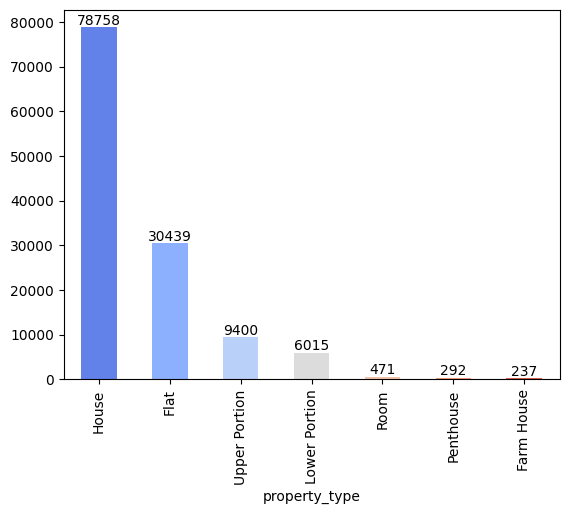

In [26]:
# Most units available

colors = sns.color_palette("coolwarm", len(df.property_type.value_counts()))

ax = df.property_type.value_counts().plot(kind='bar', color=colors)

for i in ax.containers:
    ax.bar_label(i)

plt.show()



In [27]:
# 2- Calculate the average price for each city ?

average_price_by_city = df.groupby('city')['price'].mean().round(2)
print(f"average price for each region : \n\n{average_price_by_city}")


average price for each region : 

city
Faisalabad     9138800.87
Islamabad     13255283.43
Karachi       18915584.87
Lahore        24900890.41
Rawalpindi     9565625.79
Name: price, dtype: float64


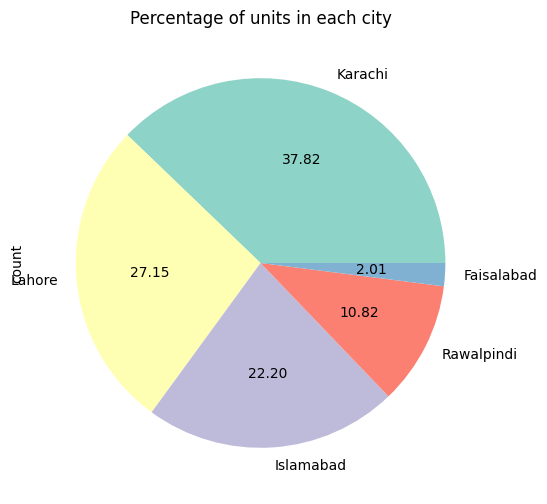

In [28]:
# precentage of units in each cit
import matplotlib.pyplot as plt
import seaborn as sns

city_counts = df.city.value_counts()

colors = sns.color_palette("Set3", len(city_counts))

ax = city_counts.plot(kind='pie', autopct='%.2f', figsize=(6, 6), colors=colors)

ax.set_title('Percentage of units in each city')


plt.show()


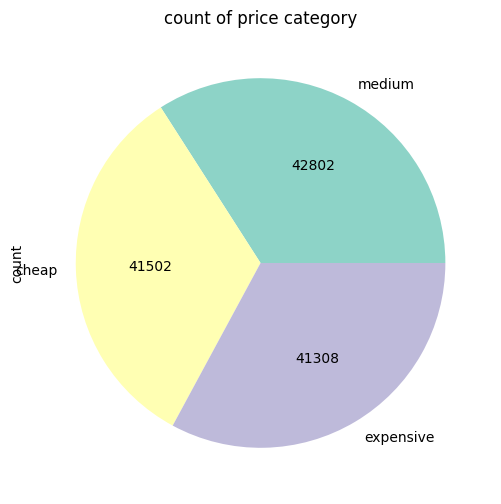

In [29]:
# Count Of category Price
price_category_counts = df.price_category.value_counts()
colors = sns.color_palette("Set3", len(price_category_counts))

ax = price_category_counts.plot(kind='pie', autopct=lambda p: f'{int(p*sum(price_category_counts)/100)}', figsize=(6, 6), colors=colors)

ax.set_title('count of price category')


plt.show()

In [30]:
#  top 10 location Avg Priec by
avg_price_by_location = df.groupby('location')['price'].mean().sort_values(ascending=False)

top_10_locations = avg_price_by_location.head(10).round()

print(f'top 10 location Avg Priec by :\n{top_10_locations}')

top 10 location Avg Priec by :
location
Chirah                       300000000.0
Mall Road                    269783750.0
GOR                          194250000.0
Lahore Cantt Coop Housing    180000000.0
Shah Rasool Colony           180000000.0
Tumair                       151100000.0
Budduke Manak Road           150000000.0
Darul Aman Society           140000000.0
Abdullah Ahmed Road          130000000.0
Maulana Shaukat Ali Road     130000000.0
Name: price, dtype: float64


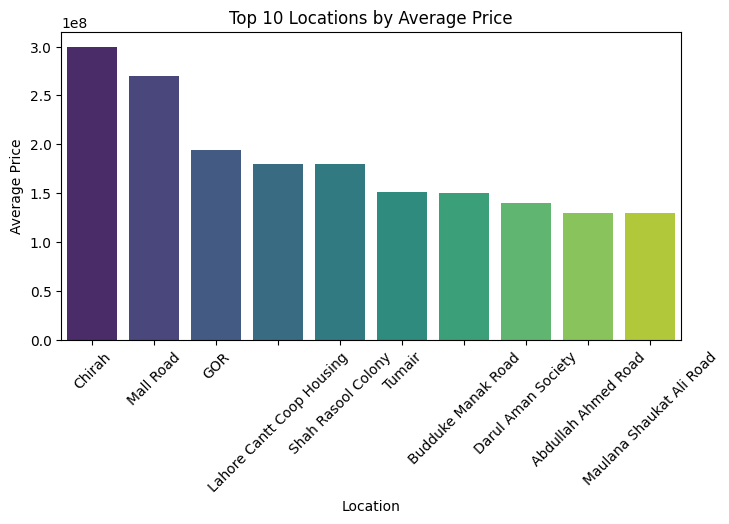

In [31]:

plt.figure(figsize=(8, 4))
sns.barplot(x=top_10_locations.index, y=top_10_locations.values, palette='viridis')
plt.title('Top 10 Locations by Average Price')
plt.xlabel('Location')
plt.ylabel('Average Price')
plt.xticks(rotation=45)
plt.show()

In [32]:
# top 10 agency by Avg Priec  
avg_price_by_agency = df.groupby('agency')['price'].mean().sort_values(ascending=False)

top_10_agency = avg_price_by_agency.head(10).round()

print(f'top 10 agency by Avg Priec :\n{top_10_agency}')

top 10 agency by Avg Priec :
agency
Chishti Real Estate Advisors & Builders    1.004250e+09
21st Century Estate & Construction         3.700000e+08
AN Estate Corporation                      3.300000e+08
Farmerz Property Zone                      3.300000e+08
Silver Estate Consultants                  3.200000e+08
Virtual Estate & Traders                   3.100000e+08
Rehmans Real Estate Consultants            2.768667e+08
Ayan Estate & Builders                     2.720833e+08
Punjaab Estates                            2.445000e+08
Al Khalid Enterprises                      2.333333e+08
Name: price, dtype: float64


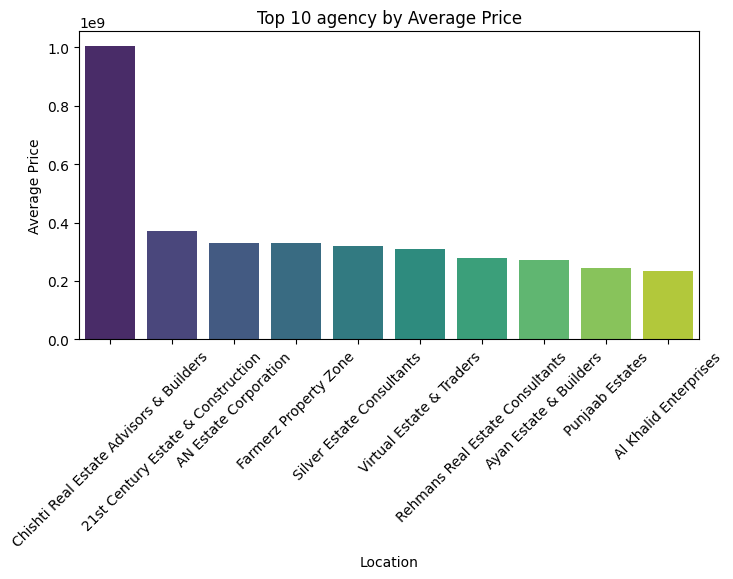

In [33]:

plt.figure(figsize=(8, 4))
sns.barplot(x=top_10_agency.index, y=top_10_agency.values, palette='viridis')
plt.title('Top 10 agency by Average Price')
plt.xlabel('Location')
plt.ylabel('Average Price')
plt.xticks(rotation=45)
plt.show()

In [34]:
df['date_added_year'].value_counts

<bound method IndexOpsMixin.value_counts of 0         2019
1         2019
2         2019
3         2019
4         2019
          ... 
125607    2019
125608    2019
125609    2019
125610    2019
125611    2019
Name: date_added_year, Length: 125612, dtype: int32>

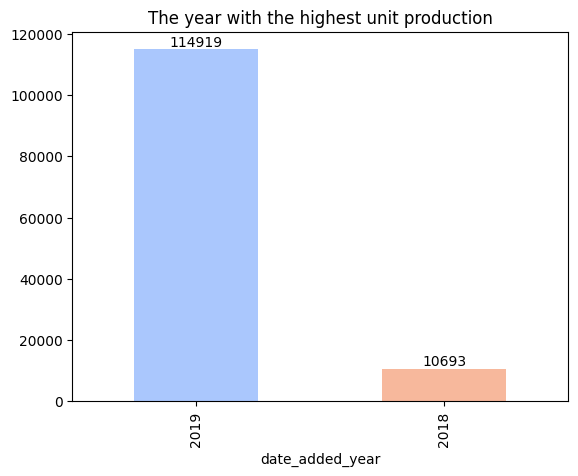

In [35]:

colors = sns.color_palette("coolwarm", len(df.date_added_year.value_counts()))

ax = df.date_added_year.value_counts().plot(kind='bar', color=colors)

for i in ax.containers:
    ax.bar_label(i)
plt.title('The year with the highest unit production')
plt.show()


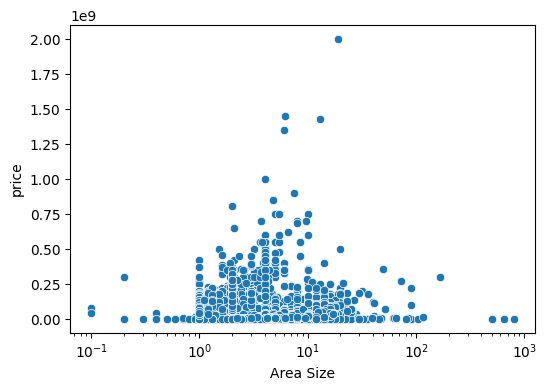

In [36]:
# Analyze the relationship between area and price using a graph
plt.figure(figsize = (6,4))
sns.scatterplot(x = 'Area Size', y = 'price', data = df)
plt.xscale('log')
plt.show()

/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


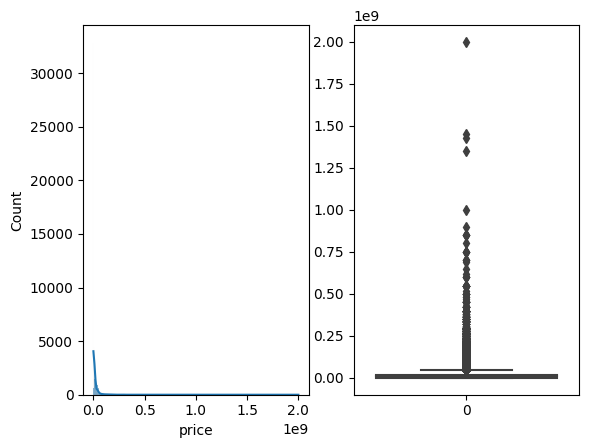

/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


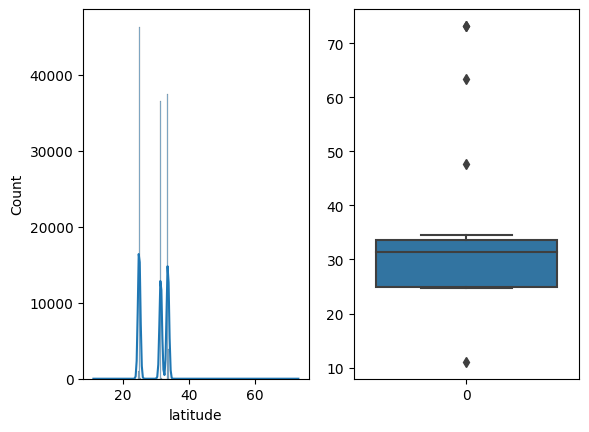

/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


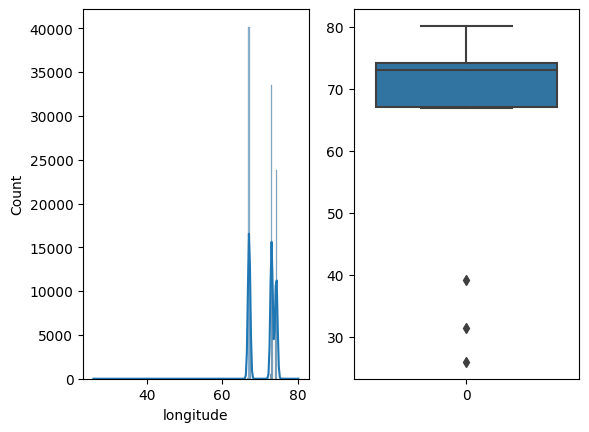

/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


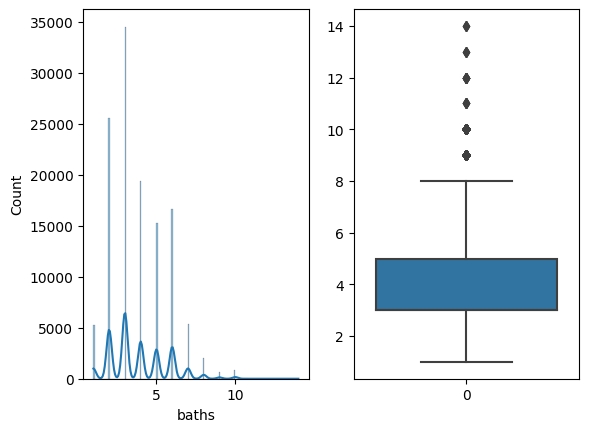

/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


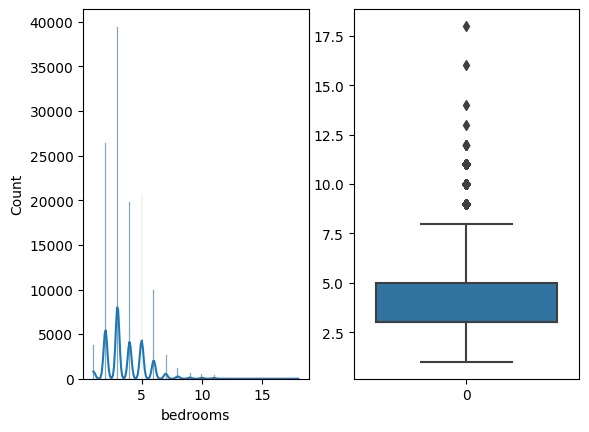

/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


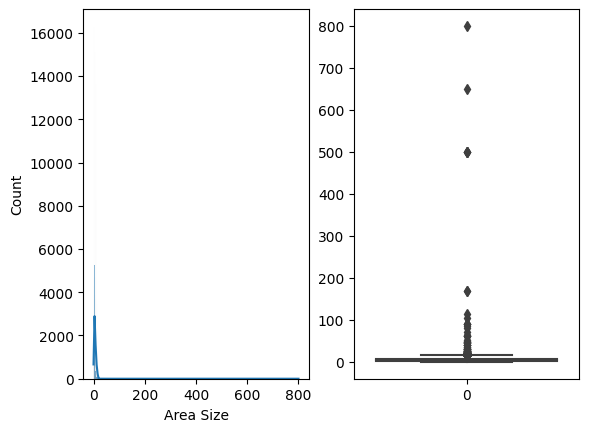

/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


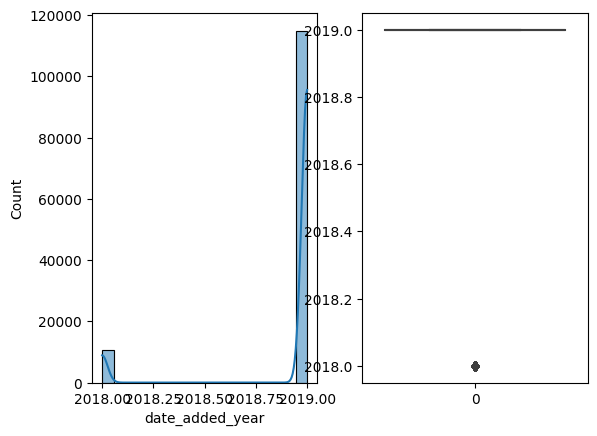

/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


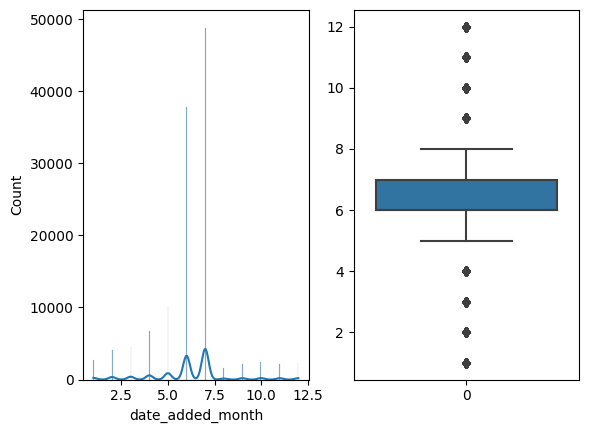

/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


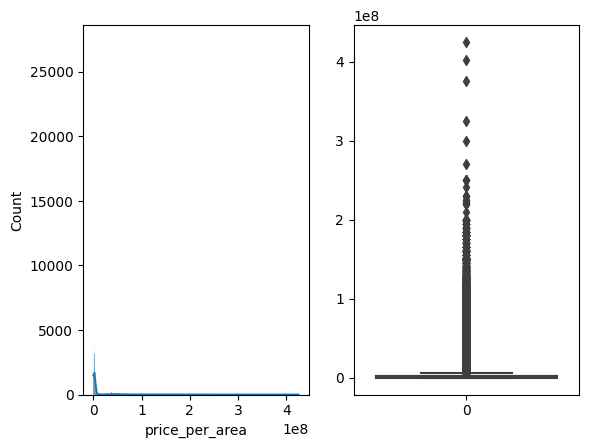

In [37]:

# uni-variate
num_cols = df.select_dtypes(include='number').columns

for col in num_cols:
    fig, axes = plt.subplots(nrows=1, ncols=2)
    sns.histplot(df[col], kde=True, ax=axes[0])
    sns.boxplot(df[col], ax=axes[1])
    plt.show()

# price & Area size --> right skewed => use LOG
# Bath & badroom --> right skewed => ub_lb


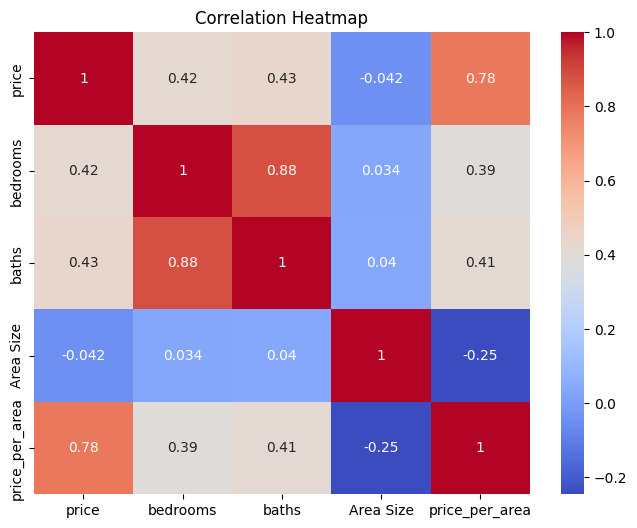

In [38]:
# bi-variate

correlation_matrix = df[['price', 'bedrooms', 'baths', 'Area Size',"price_per_area"]].corr()

plt.figure(figsize=(8, 6))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm')
plt.title('Correlation Heatmap')
plt.show()

/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  

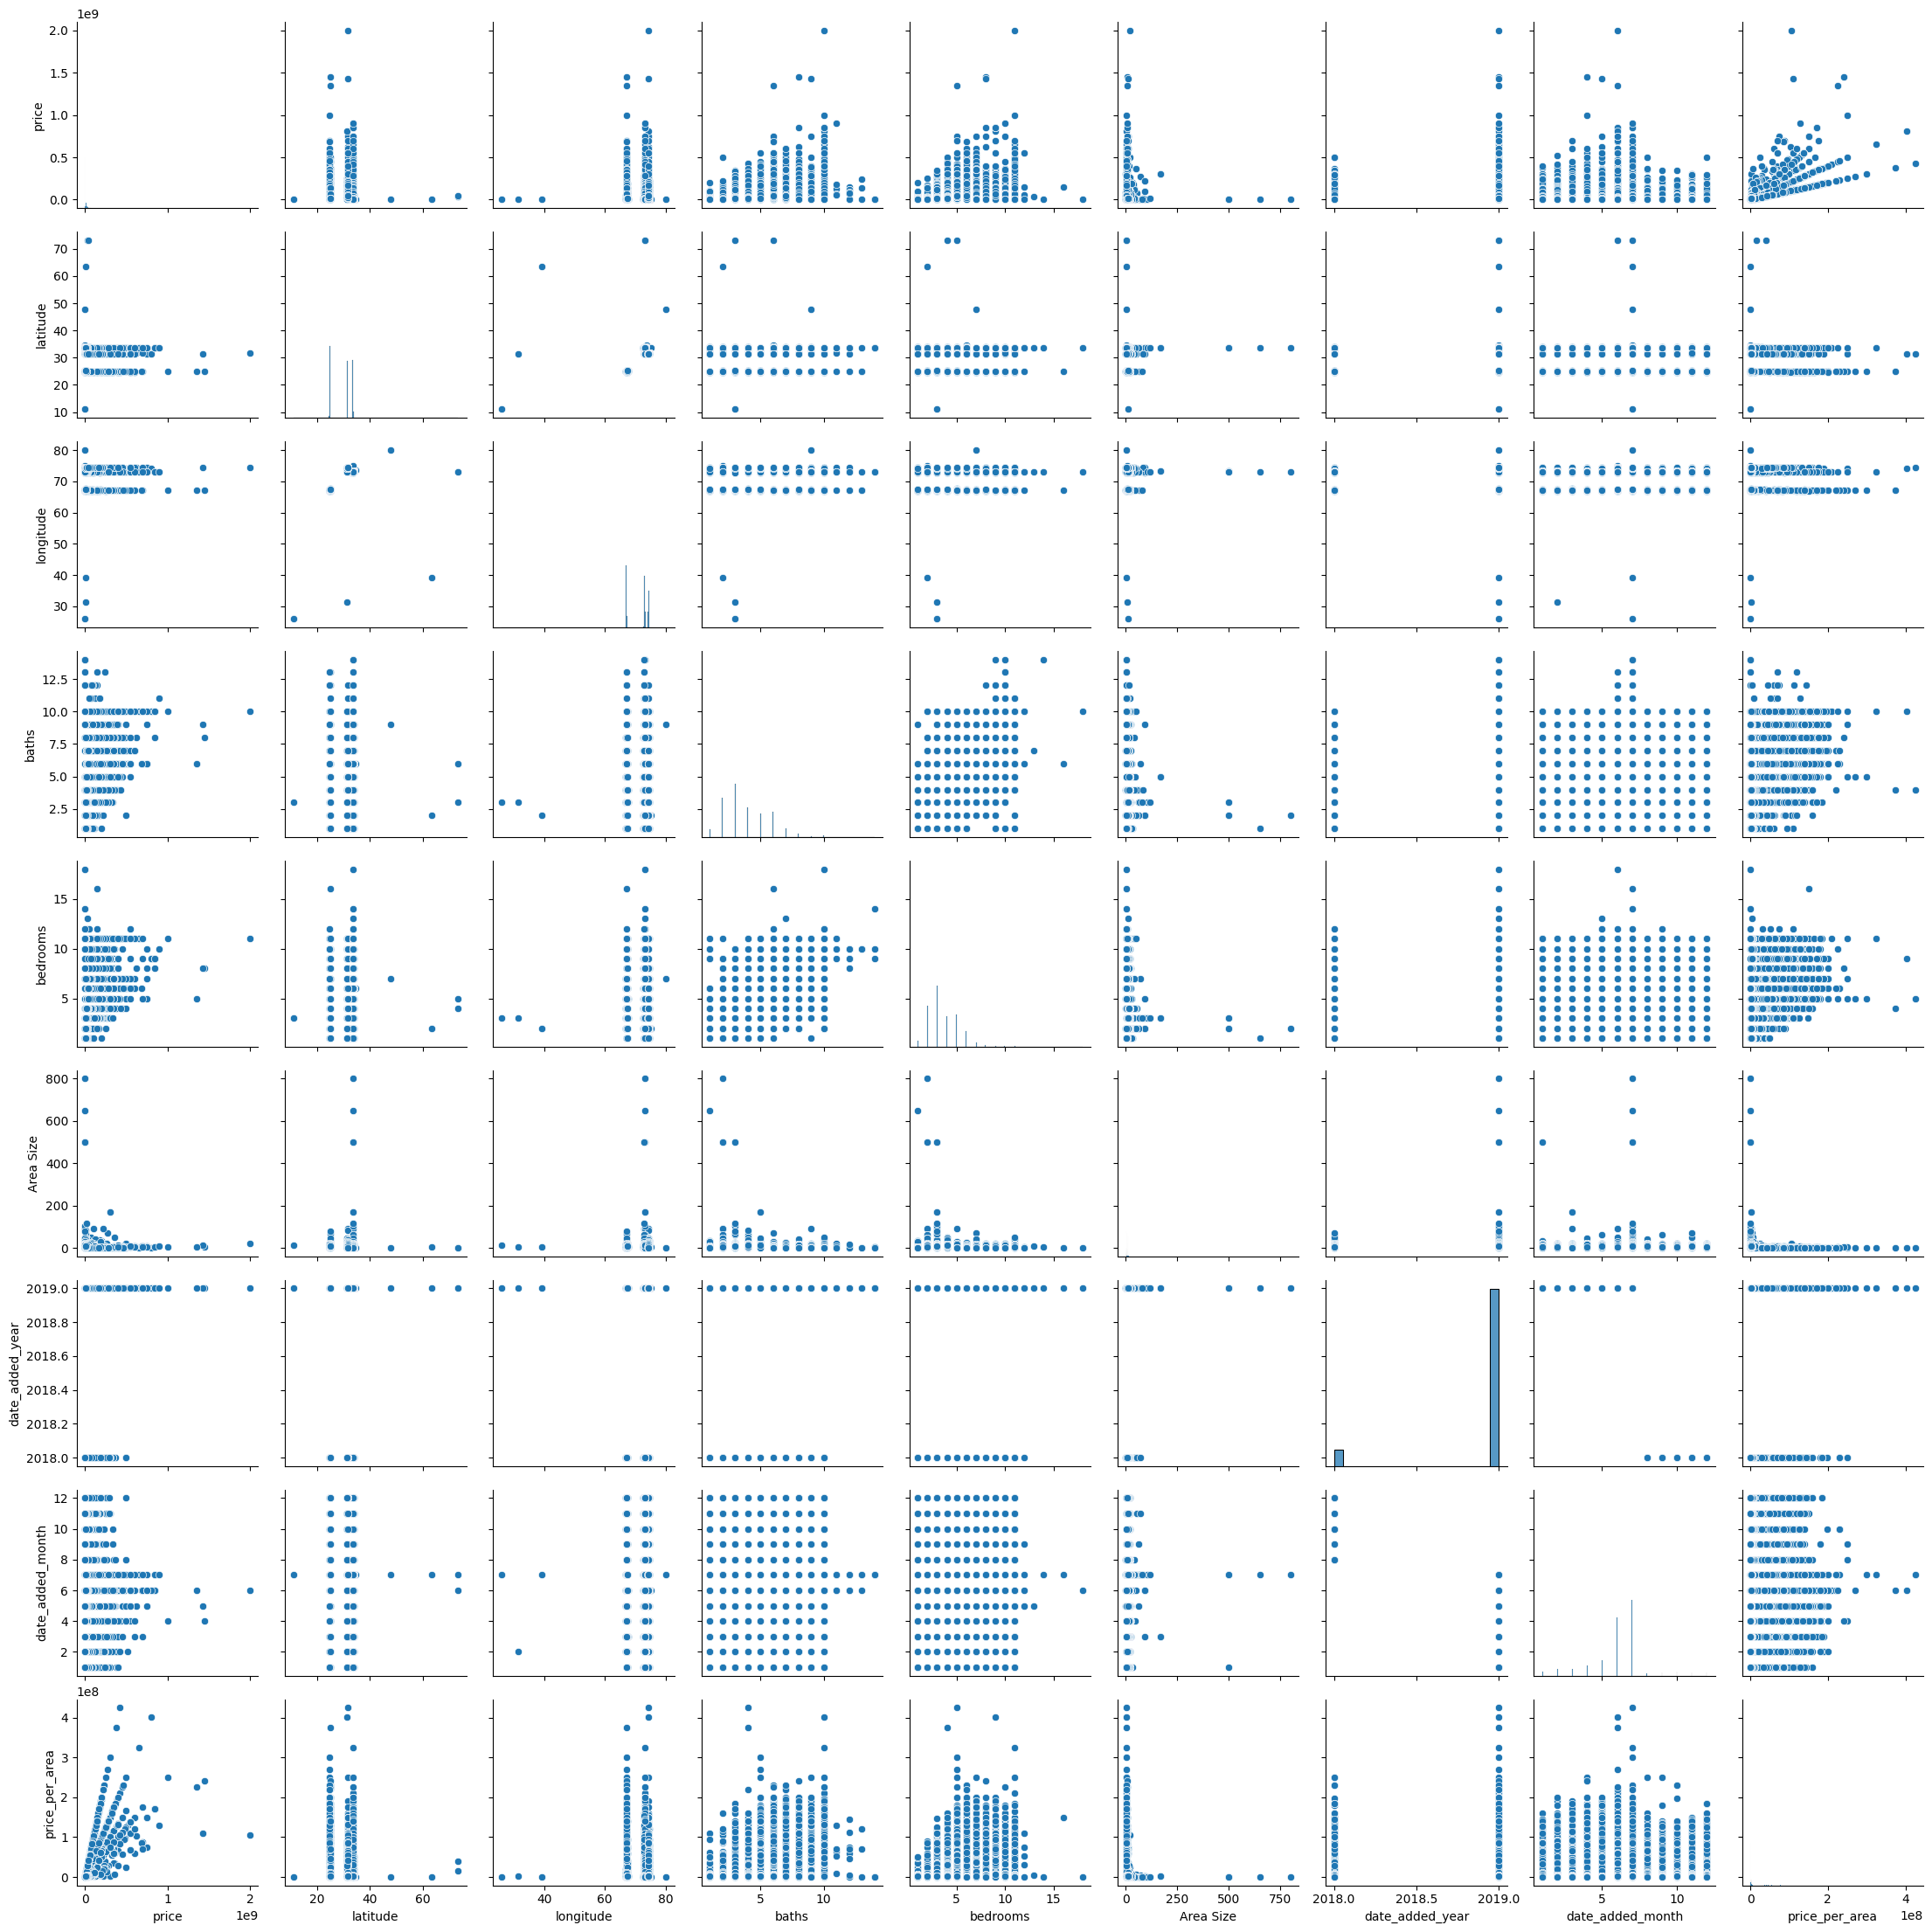

In [39]:
# multi-variate
sns.pairplot(df)

# pre-processing


In [40]:
# chek nulls
df.isnull().sum()

property_type           0
price                   0
location                0
city                    0
province_name           0
latitude                0
longitude               0
baths                   0
purpose                 0
bedrooms                0
agency              37048
agent               37048
Area Type               0
Area Size               0
date_added_year         0
date_added_month        0
date_added_day          0
price_per_area          0
price_category          0
dtype: int64

In [41]:
# Drop NaN
df.dropna(inplace=True)

In [42]:
# chek nulls
df.isnull().sum()

property_type       0
price               0
location            0
city                0
province_name       0
latitude            0
longitude           0
baths               0
purpose             0
bedrooms            0
agency              0
agent               0
Area Type           0
Area Size           0
date_added_year     0
date_added_month    0
date_added_day      0
price_per_area      0
price_category      0
dtype: int64

In [43]:
# chek duplicat
df.duplicated().sum()

9914

In [44]:
# Drop Duplicat
df.drop_duplicates(inplace=True)
df.reset_index(drop=True, inplace=True)
df

,property_type,price,location,city,province_name,latitude,longitude,baths,purpose,bedrooms,agency,agent,Area Type,Area Size,date_added_year,date_added_month,date_added_day,price_per_area,price_category
0,House,7000000,DHA Defence,Islamabad,Islamabad Capital,33.492591,73.301339,3,For Sale,3,Easy Property,Muhammad Junaid Ceo Muhammad Shahid Director,Marla,8.0,2019,7,Wednesday,8.750000e+05,cheap
1,Flat,7800000,E-11,Islamabad,Islamabad Capital,33.698244,72.984238,2,For Sale,2,Ettemad Enterprises,Balqiaz Marwat,Marla,6.2,2019,5,Sunday,1.300000e+06,medium
2,House,50000000,DHA Defence,Islamabad,Islamabad Capital,33.540894,73.095732,7,For Sale,7,Easy Property,Muhammad Junaid Ceo Muhammad Shahid Director,Kanal,1.0,2018,10,Friday,5.000000e+07,expensive
3,Penthouse,40000000,F-11,Islamabad,Islamabad Capital,33.679211,72.988787,5,For Sale,5,Crown Associate,Abrar Ahmed,Kanal,1.0,2019,6,Thursday,4.000000e+07,expensive
4,Flat,35000000,Diplomatic Enclave,Islamabad,Islamabad Capital,33.728873,73.119628,3,For Sale,3,Al Sahar Estate,Zahid H. Usmani,Marla,7.1,2019,6,Monday,5.000000e+06,expensive
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
78645,House,20500000,DHA Defence,Lahore,Punjab,31.494408,74.437666,4,For Sale,3,Lahore Grande Estate,M Shoaib,Marla,10.0,2019,7,Thursday,2.050000e+06,medium
78646,House,42500000,DHA Defence,Lahore,Punjab,31.471571,74.445906,6,For Sale,5,Syed Brothers (Pvt) Ltd. (Ph: 5 DHA),Shehroz Ali,Kanal,1.0,2019,7,Thursday,4.250000e+07,expensive
78647,House,14000000,Bahria Town Karachi,Karachi,Sindh,24.894076,67.027715,4,For Sale,3,Linkers Realty,Ejaz,Marla,6.0,2019,7,Thursday,2.333333e+06,expensive
78648,House,14000000,Bahria Town Karachi,Karachi,Sindh,25.058062,67.306626,3,For Sale,3,ZPN Real Estate & Builders,Ali Raza,Marla,8.0,2019,7,Thursday,1.750000e+06,medium


In [45]:
# Handle_outliers
df["price"] = np.log(df["price"]+1)
df["Area Size"] = np.log(df["Area Size"]+1)
df["price_per_area"] = np.log(df["price_per_area"]+1)


<Axes: >

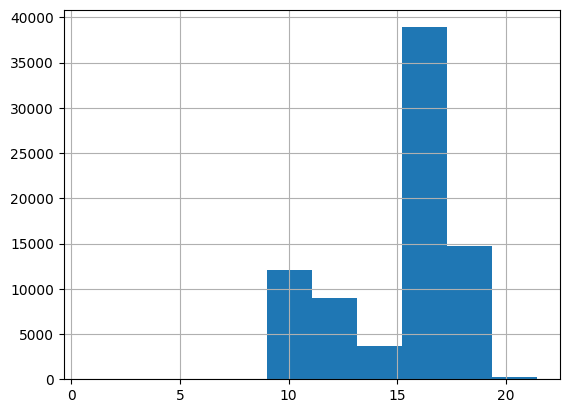

In [46]:
df['price'].hist()

<Axes: >

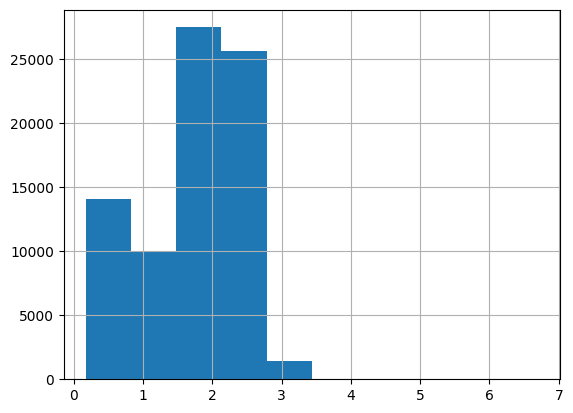

In [47]:
df["Area Size"].hist()

In [48]:
from sklearn.model_selection import train_test_split

X = df.drop('price', axis=1)
y = df['price']


In [49]:
# Splitting Data into Testing and Training



X_train,X_test,Y_train,Y_test = train_test_split(X,y,test_size = 0.2,random_state = 42,shuffle=True)

X_train.shape, X_test.shape


((62920, 18), (15730, 18))

In [50]:
# Handle_outliers
from sklearn.base import BaseEstimator, TransformerMixin

class Handle_outliers_lb_ub(BaseEstimator, TransformerMixin):
    
    def fit(self, X, y=None):
        self.n_features_in_ = X.shape[1] 
        q1 = np.percentile(X, 25)
        q3 = np.percentile(X, 75)
        iqr = q3 - q1
        ub_train = q3 + 1.5 * iqr
        lb_train = q1 - 1.5 * iqr
        self.ub_train = ub_train
        self.lb_train = lb_train
        return self # always return self

    def transform(self, X, y=None):
        assert self.n_features_in_ == X.shape[1]
        X[X > self.ub_train] = self.ub_train
        X[X < self.lb_train] = self.lb_train
        return X
    
h_lb_ub = Handle_outliers_lb_ub()
h_lb_ub

Handle_outliers_lb_ub()

In [51]:
from sklearn.base import BaseEstimator, TransformerMixin
class LogTransfomer(BaseEstimator, TransformerMixin):

    def fit(self, x, y=None):

        self.n_features_in_ = x.shape[1] 
        return self 
    
    def transform(self, x, y=None):
        assert self.n_features_in_ == x.shape[1]
        return np.log1p(x)
    
log_transformer = LogTransfomer()
log_transformer

LogTransfomer()

In [52]:
num_pipeline = Pipeline(steps=[
    ('Impute', SimpleImputer(strategy='median')),
    ('handle_outliers', Handle_outliers_lb_ub()),
    ('poly', PolynomialFeatures(degree=2, include_bias=False)),
    ('scale', StandardScaler())
])

ordinal_pipeline = Pipeline(steps=[
    ('Impute', SimpleImputer(strategy='most_frequent')),
    ('ecnode', OrdinalEncoder(categories=[['For Rent', 'For Sale'],
                                          ['Marla','Kanal'],
                                          ]))
]
)

nominal_ohe_pipeline = Pipeline(steps=[
    ('Impute', SimpleImputer(strategy='most_frequent')),
    ('ecnode', OneHotEncoder(drop='first', sparse_output=False))
]
)

nominal_be_pipeline = Pipeline(steps=[
    ('Impute', SimpleImputer(strategy='most_frequent')),
    ('ecnode', BinaryEncoder())
]
)

target_pipeline = Pipeline(steps=[
    ('handle_outliers', LogTransfomer())
])

In [53]:
X_train.city.unique()

array(['Lahore', 'Karachi', 'Rawalpindi', 'Islamabad', 'Faisalabad'],
      dtype=object)

In [54]:
pre_processing = ColumnTransformer(transformers=[
    ("num_pipeline", num_pipeline, ['baths', 'bedrooms']),
    ("ordinal_pipeline", ordinal_pipeline, ['purpose','Area Type']),  
    ("nominal_ohe_pipeline", nominal_ohe_pipeline, ['property_type','province_name','city','price_category']),
    ("nominal_be_pipeline", nominal_be_pipeline, ["location","agency",'agent','date_added_day']) 
])

pre_processing


ColumnTransformer(transformers=[('num_pipeline',
                                 Pipeline(steps=[('Impute',
                                                  SimpleImputer(strategy='median')),
                                                 ('handle_outliers',
                                                  Handle_outliers_lb_ub()),
                                                 ('poly',
                                                  PolynomialFeatures(include_bias=False)),
                                                 ('scale', StandardScaler())]),
                                 ['baths', 'bedrooms']),
                                ('ordinal_pipeline',
                                 Pipeline(steps=[('Impute',
                                                  SimpleImputer(strategy='most_frequent')),
                                                 ('ecnode',
                                                  Or...
                                 Pipeline(steps=[('Impute',
                                                  SimpleImputer(strategy='most_frequent')),
                                                 ('ecnode',
                                                  OneHotEncoder(drop='first',
                                                                sparse_output=False))]),
                                 ['property_type', 'province_name', 'city',
                                  'price_category']),
                                ('nominal_be_pipeline',
                                 Pipeline(steps=[('Impute',
                                                  SimpleImputer(strategy='most_frequent')),
                                                 ('ecnode', BinaryEncoder())]),
                                 ['location', 'agency', 'agent',
                                  'date_added_day'])])

In [55]:
X_train_preprocessed = pre_processing.fit_transform(X_train)
X_test_preprocessed = pre_processing.transform(X_test)
y_train_preprocessed = target_pipeline.fit_transform(np.array(Y_train).reshape(-1, 1))
Y_test_preprocessed = target_pipeline.transform(np.array(Y_test).reshape(-1, 1))
X_train_preprocessed.shape

(62920, 61)

#  Modeling

* 1) Make Simple Model

* 2) Get validation accuracy to invstigate:
        - Underfitting vs Overfitting (bias - variance tradeoff)

* 3) Hyperparameters tunning (using GridSearchCV or RandomizedSearchCV)

* 4) Get Test Score & confidence interval

* 5) save model

* 6) put it in backend (streamlit / flaskapp)

## 1- LinearRegression

In [56]:
# lr_model = LinearRegression()
# print(f"Hyperparameters of LinearRegression:\n\n{lr_model.get_params()}")

In [57]:
lr_model = LinearRegression(fit_intercept=True)
lr_model.fit(X_train_preprocessed, y_train_preprocessed)

y_train_pred = lr_model.predict(X_train_preprocessed)
y_test_pred = lr_model.predict(X_test_preprocessed)

print(f"Train Accuracy: {lr_model.score(X_train_preprocessed, y_train_preprocessed)}")
print(f"Train Loss: {mean_squared_error(y_train_preprocessed, y_train_pred)}")


Train Accuracy: 0.9582394705038828
Train Loss: 0.0013638540599785738


In [58]:
valid_accuracies = cross_val_score(lr_model, X_train_preprocessed, y_train_preprocessed, cv=5, scoring='r2')

print(f"Validation Accuracy Mean: {valid_accuracies.mean()}")
print(f"Validation Accuracy Std: {valid_accuracies.std()}")

Validation Accuracy Mean: -5.891342002263441e+16
Validation Accuracy Std: 1.1782684004526882e+17


## More complex model

Let's try them on the normal features not polynomial features

In [59]:
from sklearn.linear_model import LinearRegression,SGDRegressor
from sklearn.ensemble import RandomForestRegressor,GradientBoostingRegressor
from sklearn.svm import SVR
from sklearn.tree import DecisionTreeRegressor
from sklearn.neighbors import KNeighborsRegressor
from xgboost import XGBRegressor



## 2- Support vector Regression - SVR

In [60]:
# svm_reg = SVR()
# print(f"Hyperparameters of SVR:\n\n{svm_reg.get_params()}")

In [61]:
svm_reg = SVR(C=3, kernel='rbf', gamma='scale', epsilon=0.1)
svm_reg.fit(X_train_preprocessed, y_train_preprocessed)
y_train_pred = svm_reg.predict(X_train_preprocessed)
print(f"Train Accuracy: {svm_reg.score(X_train_preprocessed, y_train_preprocessed)}")
print(f"Train Loss: {mean_squared_error(y_train_preprocessed, y_train_pred)}")


/usr/local/lib/python3.10/dist-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Train Accuracy: 0.939140532077183
Train Loss: 0.0019876048847126664


In [62]:
valid_accuracies = cross_val_score(svm_reg, X_train_preprocessed, y_train_preprocessed, cv=5, scoring='r2')

print(f"Validation Accuracy Mean: {valid_accuracies.mean()}")
print(f"Validation Accuracy Std: {valid_accuracies.std()}")

/usr/local/lib/python3.10/dist-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.10/dist-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.10/dist-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.10/dist-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for exam

Validation Accuracy Mean: 0.9340989750922706
Validation Accuracy Std: 0.0073843949300388505


## 3- Gradient Boosting Regressor

In [63]:
# gb_reg = GradientBoostingRegressor()
# print(f"Hyperparameters of SVR:\n\n{gb_reg.get_params()}")


In [64]:
gb_reg = GradientBoostingRegressor(n_estimators=300, min_samples_leaf=5, random_state=42)
gb_reg.fit(X_train_preprocessed, y_train_preprocessed)
y_train_pred = gb_reg.predict(X_train_preprocessed)
print(f"Train Accuracy: {gb_reg.score(X_train_preprocessed, y_train_preprocessed)}")
print(f"Train Loss: {mean_squared_error(y_train_preprocessed, y_train_pred)}")


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_gb.py:437: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Train Accuracy: 0.9687386155490106
Train Loss: 0.0010209632545008093


In [65]:
valid_accuracies = cross_val_score(gb_reg, X_train_preprocessed, y_train_preprocessed, cv=5, scoring='r2')
print(f"Validation Accuracy Mean: {valid_accuracies.mean()}")
print(f"Validation Accuracy Std: {valid_accuracies.std()}")

/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_gb.py:437: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_gb.py:437: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_gb.py:437: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_gb.py:437: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
 

Validation Accuracy Mean: 0.9678567911026998
Validation Accuracy Std: 0.009446948066670936


## 4- DecisionTreeRegressor

In [66]:
# dt_reg = DecisionTreeRegressor()
# print(f"Hyperparameters of DecisionTreeRegressor:\n\n{dt_reg.get_params()}")


In [102]:
dt_reg = DecisionTreeRegressor(criterion='squared_error',max_depth=10,min_samples_split=2,min_samples_leaf=5)
              
dt_reg.fit(X_train_preprocessed, y_train_preprocessed)

y_train_pred = dt_reg.predict(X_train_preprocessed)
y_test_pred_dt = dt_reg.predict(X_test_preprocessed)


print(f"Train Accuracy: {dt_reg.score(X_train_preprocessed, y_train_preprocessed)}")
print(f"Train Loss: {mean_squared_error(y_train_preprocessed, y_train_pred)}")




Train Accuracy: 0.9761610273864602
Train Loss: 0.0007785552524595599


In [103]:
valid_accuracies = cross_val_score(dt_reg, X_train_preprocessed, y_train_preprocessed, cv=5, scoring='r2')
print(f"Validation Accuracy Mean: {valid_accuracies.mean()}")
print(f"Validation Accuracy Std: {valid_accuracies.std()}")

Validation Accuracy Mean: 0.9713481798943677
Validation Accuracy Std: 0.007267578394594337


## 5- Random Forest Regressor

In [69]:
# rf_reg = RandomForestRegressor()
# print(f"Hyperparameters of RandomForestRegressor:\n\n{rf_reg.get_params()}")


In [120]:
print(random_search.best_score_)
print(random_search.best_params_)

-0.0007489567645504791
{'n_estimators': 200, 'min_samples_leaf': 1, 'max_features': 'sqrt', 'max_depth': 20, 'bootstrap': False}


In [121]:
rf_reg = RandomForestRegressor(n_estimators=200,max_depth=20,max_features='sqrt',min_samples_leaf=1,bootstrap=False)

rf_reg.fit(X_train_preprocessed, y_train_preprocessed)
y_train_pred = rf_reg.predict(X_train_preprocessed)

print(f"Train Accuracy: {rf_reg.score(X_train_preprocessed, y_train_preprocessed)}")
print(f"Train Loss: {mean_squared_error(y_train_preprocessed, y_train_pred)}")



<ipython-input-121-e29f21605a3e>:3: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_reg.fit(X_train_preprocessed, y_train_preprocessed)


Train Accuracy: 0.9979337032853525
Train Loss: 6.748303236084183e-05


In [122]:
valid_accuracies = cross_val_score(rf_reg, X_train_preprocessed, y_train_preprocessed, cv=5, scoring='r2')
print(f"Validation Accuracy Mean: {valid_accuracies.mean()}")
print(f"Validation Accuracy Std: {valid_accuracies.std()}")

/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py:686: DataConversionWarning: A column-vector y was passed whe

Validation Accuracy Mean: 0.9772061456855091
Validation Accuracy Std: 0.0064902699737715164


## 6- Extreme Gradient Boosting Regressor

In [129]:
xgb_reg = XGBRegressor(
    subsample=0.8, 
    n_estimators=300, 
    min_child_weight=5, 
    max_depth=7, 
    learning_rate=0.05, 
    gamma=0, 
    colsample_bytree=0.7,
    random_state=42  
)

xgb_reg.fit(X_train_preprocessed, y_train_preprocessed)
y_train_pred = xgb_reg.predict(X_train_preprocessed)

print(f"Train Accuracy: {xgb_reg.score(X_train_preprocessed, y_train_preprocessed)}")
print(f"Train Loss: {mean_squared_error(y_train_preprocessed, y_train_pred)}")


Train Accuracy: 0.9834610990790877
Train Loss: 0.000540142748205979


In [74]:
from sklearn.model_selection import KFold


The history saving thread hit an unexpected error (OperationalError('attempt to write a readonly database')).History will not be written to the database.


In [130]:


# Manual cross-validation as a workaround
kf = KFold(n_splits=5, shuffle=True, random_state=42)
valid_accuracies = []

for train_idx, valid_idx in kf.split(X_train_preprocessed):
    X_train_cv, X_valid_cv = X_train_preprocessed[train_idx], X_train_preprocessed[valid_idx]
    y_train_cv, y_valid_cv = y_train_preprocessed[train_idx], y_train_preprocessed[valid_idx]
    
    xgb_reg.fit(X_train_cv, y_train_cv)
    valid_score = xgb_reg.score(X_valid_cv, y_valid_cv)
    valid_accuracies.append(valid_score)

valid_accuracies_df = pd.DataFrame(valid_accuracies, columns=["Validation Accuracy"])

print(f"Validation Accuracy Mean: {np.mean(valid_accuracies)}")
print(f"Validation Accuracy Std: {np.std(valid_accuracies)}")


Validation Accuracy Mean: 0.9770116941508595
Validation Accuracy Std: 0.0075292456314558194


In [76]:
# valid_accuracies = cross_val_score(xgb_reg, X_train_preprocessed, y_train_preprocessed, cv=5, scoring='r2')
# print(f"Validation Accuracy Mean: {valid_accuracies.mean()}")
# print(f"Validation Accuracy Std: {valid_accuracies.std()}")

## 7- KNeighborsRegressor

In [77]:
# knn_reg = KNeighborsRegressor()
# print(f"Hyperprametar in : \n\n{knn_reg.get_params}")

In [78]:
knn_reg = KNeighborsRegressor(n_neighbors=10,weights='distance', algorithm='auto')
knn_reg.fit(X_train_preprocessed, y_train_preprocessed)
y_train_pred = knn_reg.predict(X_train_preprocessed)
print(f"Train Accuracy: {knn_reg.score(X_train_preprocessed, y_train_preprocessed)}")
print(f"Train Loss: {mean_squared_error(y_train_preprocessed, y_train_pred)}")


Train Accuracy: 0.9984469286185166
Train Loss: 5.072164396932944e-05


In [80]:
valid_accuracies = cross_val_score(knn_reg, X_train_preprocessed, y_train_preprocessed, cv=9, scoring='r2')
print(f"Validation Accuracy Mean: {valid_accuracies.mean()}")
print(f"Validation Accuracy Std: {valid_accuracies.std()}")

Validation Accuracy Mean: 0.8603951059866095
Validation Accuracy Std: 0.010872214911421634


## Hyperparameters tunning on 7 Models you think will work best


**(using GridSearchCV or RandomizedSearchCV)**

In [81]:
#Gridsearch LinearRegression
lr_pipeline = Pipeline(steps=[
    ("preprocessing", pre_processing),
    ("model", LinearRegression())
    ])

lr_pipeline

Pipeline(steps=[('preprocessing',
                 ColumnTransformer(transformers=[('num_pipeline',
                                                  Pipeline(steps=[('Impute',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('handle_outliers',
                                                                   Handle_outliers_lb_ub()),
                                                                  ('poly',
                                                                   PolynomialFeatures(include_bias=False)),
                                                                  ('scale',
                                                                   StandardScaler())]),
                                                  ['baths', 'bedrooms']),
                                                 ('ordinal_pipeline',
                                                  Pipeline(steps=[('Impute',
                                                                   SimpleImputer(strate...
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('ecnode',
                                                                   OneHotEncoder(drop='first',
                                                                                 sparse_output=False))]),
                                                  ['property_type',
                                                   'province_name', 'city',
                                                   'price_category']),
                                                 ('nominal_be_pipeline',
                                                  Pipeline(steps=[('Impute',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('ecnode',
                                                                   BinaryEncoder())]),
                                                  ['location', 'agency',
                                                   'agent',
                                                   'date_added_day'])])),
                ('model', LinearRegression())])

In [82]:
params = {
    'preprocessing__num_pipeline__poly__degree':[2, 5, 7, 9]
}

lr_grid = GridSearchCV(lr_pipeline, params, cv=5, scoring='neg_mean_squared_error')
lr_grid.fit(X_train, Y_train)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('preprocessing',
                                        ColumnTransformer(transformers=[('num_pipeline',
                                                                         Pipeline(steps=[('Impute',
                                                                                          SimpleImputer(strategy='median')),
                                                                                         ('handle_outliers',
                                                                                          Handle_outliers_lb_ub()),
                                                                                         ('poly',
                                                                                          PolynomialFeatures(include_bias=False)),
                                                                                         ('scale',
                                                                                          StandardScaler())]),
                                                                         ['baths',
                                                                          'bedrooms']),
                                                                        ('ordinal_pipeline',
                                                                         Pipeline(steps=[('...
                                                                         ['property_type',
                                                                          'province_name',
                                                                          'city',
                                                                          'price_category']),
                                                                        ('nominal_be_pipeline',
                                                                         Pipeline(steps=[('Impute',
                                                                                          SimpleImputer(strategy='most_frequent')),
                                                                                         ('ecnode',
                                                                                          BinaryEncoder())]),
                                                                         ['location',
                                                                          'agency',
                                                                          'agent',
                                                                          'date_added_day'])])),
                                       ('model', LinearRegression())]),
             param_grid={'preprocessing__num_pipeline__poly__degree': [2, 5, 7,
                                                                       9]},
             scoring='neg_mean_squared_error')

In [83]:
print(lr_grid.best_score_)
print(lr_grid.best_params_)

-0.24843393509624737
{'preprocessing__num_pipeline__poly__degree': 5}


In [110]:
#Gridsearch DecisionTreeRegressor
dt_reg = DecisionTreeRegressor()
param_grid = {
    'criterion': ['squared_error', 'mae'], 
    'max_depth': [5, 10, 15],  
    'min_samples_split': [2, 5],  
    'min_samples_leaf': [1, 2],  
}
dt_reg = GridSearchCV(estimator=dt_reg, param_grid=param_grid, cv=3, scoring='neg_mean_squared_error', n_jobs=-1)
dt_reg.fit(X_train_preprocessed, y_train_preprocessed)

/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py:378: FitFailedWarning: 
36 fits failed out of a total of 72.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
11 fits failed with the following error:
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/lib/python3.10/dist-packages/sklearn/tree/_classes.py", line 1247, in fit
    super().fit(
  File "/usr/local/lib/python3.10/dist-packages/sklearn/tree/_classes.py", line 177, in fit
    self._validate_params()
  File "/usr/local/lib/python3.10/dist-packages/sklearn/base.py", line 600, in _valida

GridSearchCV(cv=3, estimator=DecisionTreeRegressor(), n_jobs=-1,
             param_grid={'criterion': ['squared_error', 'mae'],
                         'max_depth': [5, 10, 15], 'min_samples_leaf': [1, 2],
                         'min_samples_split': [2, 5]},
             scoring='neg_mean_squared_error')

In [111]:
print(dt_reg.best_score_)
print(dt_reg.best_params_)

-0.0010075810502618596
{'criterion': 'squared_error', 'max_depth': 10, 'min_samples_leaf': 2, 'min_samples_split': 5}


In [119]:
#RandomizedSearchCV RandomForestRegressor
rf_reg = RandomForestRegressor()

param_grid = {
    'n_estimators': [100, 200, 300],  
    'max_depth': [10, 20, 30, None],  
    'max_features': ['sqrt', 'log2', None],  
    'min_samples_leaf': [1, 2, 4, 5],  
    'bootstrap': [True, False]  
}

random_search = RandomizedSearchCV(estimator=rf_reg, param_distributions=param_grid, n_iter=10, cv=5, scoring='neg_mean_squared_error', n_jobs=-1, random_state=42)


random_search.fit(X_train_preprocessed, y_train_preprocessed)

/usr/local/lib/python3.10/dist-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_search.py:909: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self.best_estimator_.fit(X, y, **fit_params)


RandomizedSearchCV(cv=5, estimator=RandomForestRegressor(), n_jobs=-1,
                   param_distributions={'bootstrap': [True, False],
                                        'max_depth': [10, 20, 30, None],
                                        'max_features': ['sqrt', 'log2', None],
                                        'min_samples_leaf': [1, 2, 4, 5],
                                        'n_estimators': [100, 200, 300]},
                   random_state=42, scoring='neg_mean_squared_error')

In [120]:
print(random_search.best_score_)
print(random_search.best_params_)

-0.0007489567645504791
{'n_estimators': 200, 'min_samples_leaf': 1, 'max_features': 'sqrt', 'max_depth': 20, 'bootstrap': False}


In [131]:
#RandomizedSearchCV XGBRegressor

xgb_reg = XGBRegressor()

param_dist = {
    'n_estimators': [100, 200, 300, 400, 500],
    'learning_rate': [0.01, 0.05, 0.1, 0.2],
    'max_depth': [3, 5, 7, 9, 11],
    'min_child_weight': [1, 3, 5],  
    'subsample': [0.6, 0.7, 0.8, 1.0],  
    'colsample_bytree': [0.6, 0.7, 0.8, 1.0],  
    'gamma': [0, 0.1, 0.2, 0.3],
}

# إعداد RandomizedSearchCV
random_search = RandomizedSearchCV(
    estimator=xgb_reg,
    param_distributions=param_dist,
    n_iter=10,  
    cv=5,  
    scoring='neg_mean_squared_error',  
    n_jobs=-1,  
    random_state=42  
)


random_search.fit(X_train_preprocessed, y_train_preprocessed)

RandomizedSearchCV(cv=5,
                   estimator=XGBRegressor(base_score=None, booster=None,
                                          callbacks=None,
                                          colsample_bylevel=None,
                                          colsample_bynode=None,
                                          colsample_bytree=None, device=None,
                                          early_stopping_rounds=None,
                                          enable_categorical=False,
                                          eval_metric=None, feature_types=None,
                                          gamma=None, grow_policy=None,
                                          importance_type=None,
                                          interaction_constraints=None,
                                          learning_rate=...
                                          n_estimators=None, n_jobs=None,
                                          num_parallel_tree=None,
                                          random_state=None, ...),
                   n_jobs=-1,
                   param_distributions={'colsample_bytree': [0.6, 0.7, 0.8,
                                                             1.0],
                                        'gamma': [0, 0.1, 0.2, 0.3],
                                        'learning_rate': [0.01, 0.05, 0.1, 0.2],
                                        'max_depth': [3, 5, 7, 9, 11],
                                        'min_child_weight': [1, 3, 5],
                                        'n_estimators': [100, 200, 300, 400,
                                                         500],
                                        'subsample': [0.6, 0.7, 0.8, 1.0]},
                   random_state=42, scoring='neg_mean_squared_error')

In [124]:

print(random_search.best_score_)
print(random_search.best_params_)

-0.0006501166992596453
{'subsample': 0.8, 'n_estimators': 300, 'min_child_weight': 5, 'max_depth': 11, 'learning_rate': 0.05, 'gamma': 0, 'colsample_bytree': 0.7}


# confidenece inteval

In [134]:
xgb_reg = XGBRegressor(
    subsample=0.8, 
    n_estimators=300, 
    min_child_weight=5, 
    max_depth=7, 
    learning_rate=0.05, 
    gamma=0, 
    colsample_bytree=0.7,
    random_state=42  
)
xgb_reg.fit(X_train_preprocessed, y_train_preprocessed)
y_train_pred = xgb_reg.predict(X_train_preprocessed)

losses = (y_test_pred - Y_test_preprocessed) ** 2

confidence = 0.95
rmse_confidence_interval = np.sqrt(stats.t.interval(
    confidence, len(losses) - 1, loc=np.mean(losses), scale=stats.sem(losses)
))

print(f"Confidence Interval for RMSE: {rmse_confidence_interval}")


Confidence Interval for RMSE: [[0.25378181 0.25386404 0.25333901 ... 0.25260418 0.25210155 0.2523036 ]
 [0.2562632  0.25618174 0.25670096 ... 0.25742409 0.25791636 0.2577187 ]]


#  save model in pkl file then build backend API

In [135]:
import joblib


joblib.dump(xgb_reg, 'xgb_regressor_model.pkl')

loaded_model = joblib.load('xgb_regressor_model.pkl')

y_test_pred_loaded = loaded_model.predict(X_test_preprocessed)
